In [1]:
#@markdown Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla P100-PCIE-16GB, 16384 MiB, 16276 MiB


## Подготовка данных

1. Собрать датасет от 15 изображений одно персонажа (Чем более разнооразнее и больше данных тем лучше будет качество)
2. Кропнуть и заресайзить лица, тут можно обрабатывать сразу все https://www.birme.net/



## Install Requirements

In [2]:
!git clone https://github.com/huggingface/diffusers
%pip install git+https://github.com/huggingface/diffusers
%pip install triton
%pip install accelerate transformers ftfy gradio natsort safetensors
%pip install bitsandbytes
%pip install peft

Cloning into 'diffusers'...
remote: Enumerating objects: 60371, done.
remote: Counting objects: 100% (371/371), done.
remote: Compressing objects: 100% (240/240), done.
remote: Total 60371 (delta 222), reused 211 (delta 118), pack-reused 60000
Receiving objects: 100% (60371/60371), 41.96 MiB | 17.59 MiB/s, done.
Resolving deltas: 100% (43939/43939), done.
  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-l22ig_ia
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-l22ig_ia
  Resolved https://github.com/huggingface/diffusers to commit d1e3f489e909d351ea6abced05b0cdaf3a41be7a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.28.0.dev0-py3-none-any.whl size=2083106 sha256=353f3d84c50d02ae42f813a98406c8725d8d46535f2cefde5467c69bd88b7606
  Stored in directory: /tmp/pip-ep

In [3]:
!pip list | grep torch

pytorch-ignite                           0.5.0.post2
pytorch-lightning                        2.2.2
torch                                    2.1.2
torchaudio                               2.1.2
torchdata                                0.7.1
torchinfo                                1.8.0
torchmetrics                             1.3.2
torchtext                                0.16.2
torchvision                              0.16.2


## Download model and convert model

In [4]:
import requests

url = "https://civitai.com/api/download/models/201259?type=Model&format=SafeTensor&size=pruned&fp=fp16"
output_file = "civitai_midel.ckpt"

response = requests.get(url)
with open(output_file, "wb") as f:
    f.write(response.content)

In [5]:
!wget https://raw.githubusercontent.com/CompVis/stable-diffusion/main/configs/stable-diffusion/v1-inference.yaml

--2024-04-21 12:10:39--  https://raw.githubusercontent.com/CompVis/stable-diffusion/main/configs/stable-diffusion/v1-inference.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1873 (1.8K) [text/plain]
Saving to: 'v1-inference.yaml'

v1-inference.yaml   100%[===================>]   1.83K  --.-KB/s    in 0s      

2024-04-21 12:10:39 (29.8 MB/s) - 'v1-inference.yaml' saved [1873/1873]



In [6]:
!python diffusers/scripts/convert_original_stable_diffusion_to_diffusers.py \
      --checkpoint_path='/kaggle/working/civitai_midel.ckpt'\
      --original_config_file='/kaggle/working/v1-inference.yaml'\
      --dump_path='/kaggle/working/cache_dir/models/civitai_model'\
      --scheduler_type="ddim" --prediction_type='epsilon'\
      --from_safetensors

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]
2024-04-21 12:10:47.781831: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 12:10:47.781963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 12:10:47.899561: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
config.json: 100%|█████████████████████████| 4.52k/4.52k [00:00<00:00, 14.9MB/s]
tokenizer_config.json: 100%|█████

## Settings and run

# Start Training

Use the table below to choose the best flags based on your memory and speed requirements. Tested on Tesla T4 GPU.


| `fp16` | `train_batch_size` | `gradient_accumulation_steps` | `gradient_checkpointing` | `use_8bit_adam` | GB VRAM usage | Speed (it/s) |
| ---- | ------------------ | ----------------------------- | ----------------------- | --------------- | ---------- | ------------ |
| fp16 | 1                  | 1                             | TRUE                    | TRUE            | 9.92       | 0.93         |
| no   | 1                  | 1                             | TRUE                    | TRUE            | 10.08      | 0.42         |
| fp16 | 2                  | 1                             | TRUE                    | TRUE            | 10.4       | 0.66         |
| fp16 | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 1.14         |
| no   | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 0.49         |
| fp16 | 1                  | 2                             | TRUE                    | TRUE            | 11.56      | 1            |
| fp16 | 2                  | 1                             | FALSE                   | TRUE            | 13.67      | 0.82         |
| fp16 | 1                  | 2                             | FALSE                   | TRUE            | 13.7       | 0.83          |
| fp16 | 1                  | 1                             | TRUE                    | FALSE           | 15.79      | 0.77         |


Add `--gradient_checkpointing` flag for around 9.92 GB VRAM usage.

remove `--use_8bit_adam` flag for full precision. Requires 15.79 GB with `--gradient_checkpointing` else 17.8 GB.

remove `--train_text_encoder` flag to reduce memory usage further, degrades output quality.

In [34]:
exp_num = 3
rank = '32'
os.environ['RANK'] = rank

In [35]:
import os
os.environ['INSTANCE_DIR'] = "/kaggle/input/maybe-baby/dataset/instance_images"
os.environ['CLASS_DIR'] = "/kaggle/input/maybe-baby/dataset/class_images"

os.environ['MODEL_NAME'] = "/kaggle/working/cache_dir/models/civitai_model"
os.environ['OUTPUT_DIR'] = f"/kaggle/working/stable-diffusion-weights/lora/exp{exp_num}_rank{rank}"

In [36]:
!python3 /kaggle/working/diffusers/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks woman face" \
  --class_prompt="a photo of woman face " \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=1 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --gradient_accumulation_steps=1 \
  --num_class_images=500 \
  --max_train_steps=800 \
  --checkpointing_steps=800 \
  --use_8bit_adam \
  --mixed_precision="no"\
  --train_text_encoder \
  --rank=$RANK

2024-04-21 13:22:47.117298: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 13:22:47.117365: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 13:22:47.118894: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'variance_type'} was not found in config. Values will be initialized to default values.
/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed

## Inference

In [37]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display
import os

model_path = os.environ['OUTPUT_DIR']

pipe = StableDiffusionPipeline.from_pretrained("/kaggle/working/cache_dir/models/civitai_model", safety_checker=None, torch_dtype=torch.float16).to("cuda")
pipe.load_lora_weights(model_path)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
g_cuda=None

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [38]:
#@markdown Can set random seed here for reproducibility.
g_cuda = torch.Generator(device='cuda')
seed = 345252 #@param {type:"number"}
g_cuda.manual_seed(seed)

  0%|          | 0/35 [00:00<?, ?it/s]

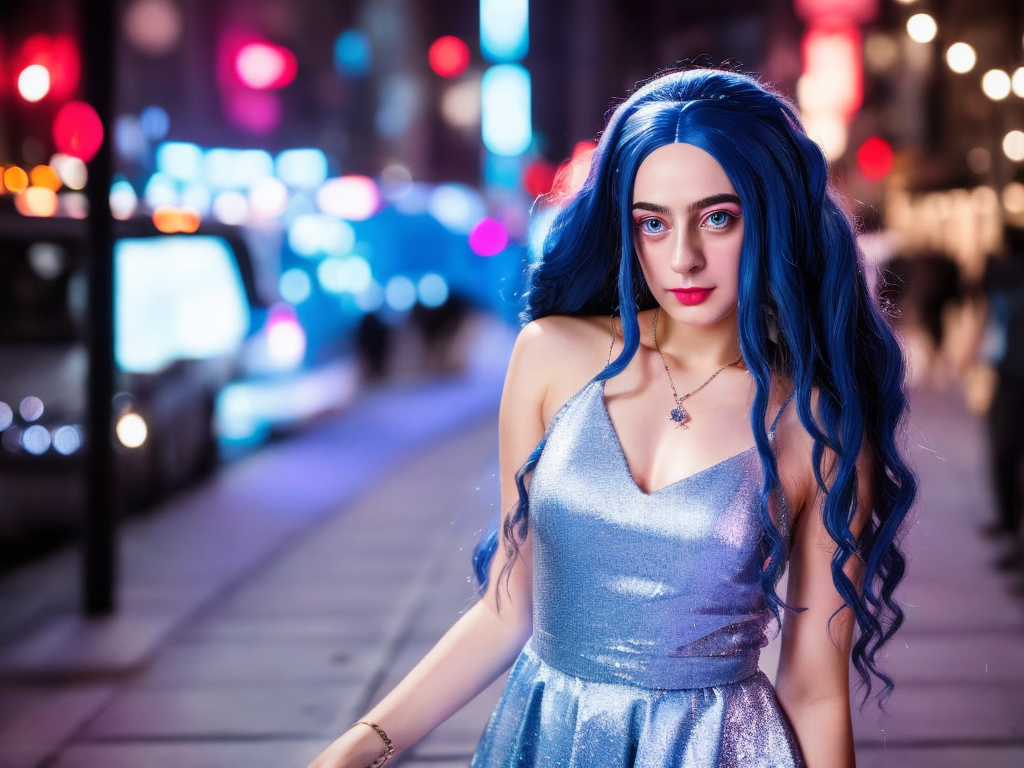

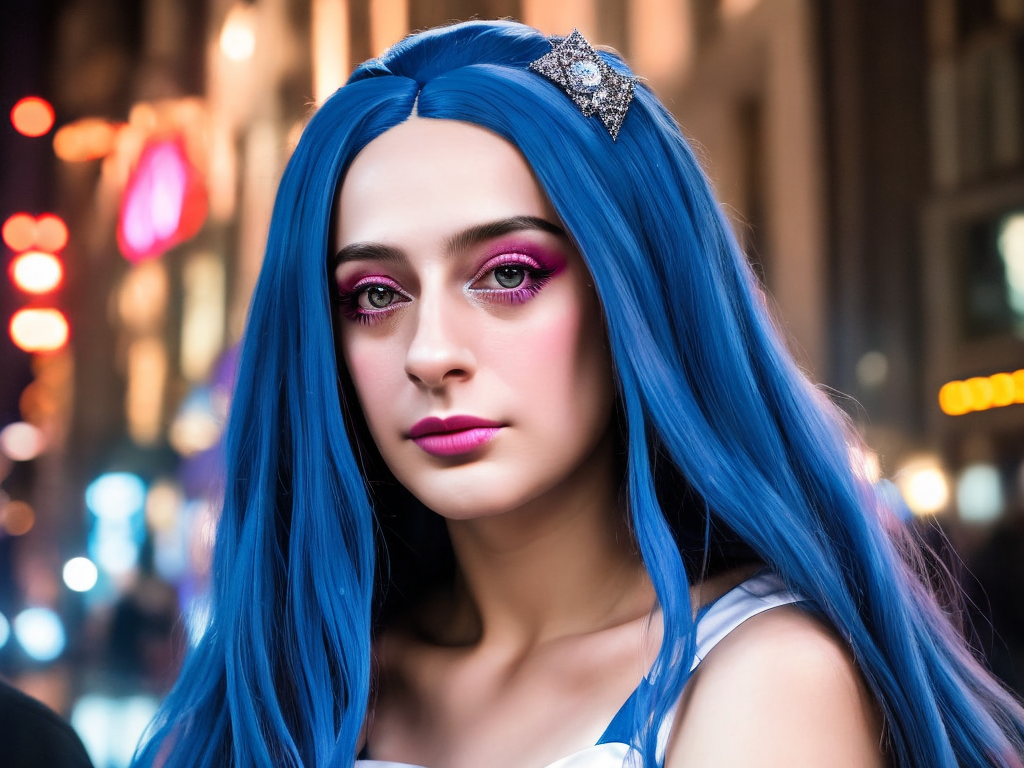

In [39]:
#@title Run for generating images.

prompt = "portrait of sks woman face, on the street, lights, midnight, NY, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus,  beautiful eyes, detailed eyes" #@param {type:"string"}
negative_prompt = "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation" #@param {type:"string"}
num_samples = 2 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 35 #@param {type:"number"}
height = 768 #@param {type:"number"}
width = 1024 #@param {type:"number"}

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)

In [40]:
token = "sks"
promt_list = [
    {
     "name": "kitchen",
     "prompt":f"close up portrait of {token} woman face, in the kitchen, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus",
     "n_prompt":"naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation",
    },
    {
     "name": "forest",
     "prompt":f"portrait of {token} woman face, in the forest, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus",
     "n_prompt":"naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation",
    },
    {
     "name": "street",
     "prompt":f"portrait of {token} woman face, on the street, lights, midnight, NY, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus,  beautiful eyes, detailed eyes",
     "n_prompt":"naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands, mutation, ugly, blurry",
    },
    {
     "name": "beach",
     "prompt":f"mid range portrait of {token} woman face, on the beach, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus",
     "n_prompt":"naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation",
    },
    {
     "name": "moon",
     "prompt":f"portrait of {token} woman face, on the moon, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus",
     "n_prompt":"naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation",
    },
]

from PIL import Image
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [41]:
seed = 147525234
repeat = 2
num_samples = 2
guidance_scale = 7.5
num_inference_steps = 35
height = 768
width = 1024

save_folder = "/kaggle/working/report_images"
save_mode = f"lora_model_exp{exp_num}_rank{rank}"

for idx, sample in enumerate(promt_list):
  prompt = sample.get("prompt")
  negative_prompt = sample.get("n_prompt")
  name = sample.get("name")
  image_list = []
  for _ in range(repeat):
    generator = torch.Generator("cuda").manual_seed(seed)
    with autocast("cuda"), torch.inference_mode():
        images = pipe(
            prompt,
            height=height,
            width=width,
            negative_prompt=negative_prompt,
            num_images_per_prompt=num_samples,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            generator=generator
        ).images
    image_list.extend(images)
    seed+=345324

  img_grid = image_grid(image_list, num_samples, repeat)
  save_path = os.path.join(save_folder, save_mode, f"{height}x{width}")
  os.makedirs(save_path, exist_ok=True)
  img_grid.save(os.path.join(save_path, f"{name}.jpg"))

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

In [42]:
torch.cuda.empty_cache()